In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, t, chi2  
from scipy.optimize import minimize, differential_evolution


In [3]:

def make_crn(M: int, N: int, seed: int = 12345):
    rng = np.random.default_rng(seed)
    Y = rng.standard_normal(M)          # (M,)
    E = rng.standard_normal((M, N))     # (M,N)
    U_chi = rng.random(M)
    eps = 1e-12
    U_chi = np.clip(U_chi, eps, 1.0 - eps)
    return Y, E, U_chi

def t_copula_uniforms_1factor_crn(
    rho: float, nu: float,
    Y: np.ndarray, E: np.ndarray, U_chi: np.ndarray
) -> np.ndarray:
    """
    Exchangeable t-copula via 1-factor with perfect CRN:
      Z = sqrt(rho)*Y + sqrt(1-rho)*E
      S = chi2.ppf(U_chi, df=nu)
      T = Z / sqrt(S/nu)
      U = t.cdf(T, df=nu)
    """
    rho = float(np.clip(rho, 1e-8, 1.0 - 1e-8))
    nu  = float(max(nu, 2.01))

    Z = np.sqrt(rho) * Y[:, None] + np.sqrt(1.0 - rho) * E
    S = chi2.ppf(U_chi, df=nu)          # (M,)
    scale = np.sqrt(S / nu)             # (M,)
    Tstu = Z / scale[:, None]
    return t.cdf(Tstu, df=nu)

Nous renseignons ici les données liées à notre CDO synthétique.

In [4]:
# Paramètres généraux
R = 0.4          # taux de récupération
N = 120          # nombre de noms
T = 5.0          # maturité (années)
r = 0.0014        # taux sans risque
M = 30000        # Monte Carlo

# Dates de paiement (annuelles)
payment_times = np.arange(1, int(T) + 1)

# Tranches (attachment, detachment)
tranches = [
    (0.00, 0.03),
    (0.03, 0.07),
    (0.07, 0.15),
    (0.15, 1.00)
]


On implémente un système de cache pour éviter les calculs de calibration et de smile à chaque fois qu'on lance le notebook.

In [5]:
import pickle
from pathlib import Path

CACHE_DIR = Path.cwd() / "cache"
CACHE_DIR.mkdir(exist_ok=True)

def save_calibration_cache(rho_t, nu_t, model_spreads, filename="calibration_cache_t.pkl"):
    cache_file = CACHE_DIR / filename
    with open(cache_file, "wb") as f:
        pickle.dump(
            {"rho_t": rho_t, "nu_t": nu_t, "model_spreads": model_spreads},
            f
        )
    print(f"Cache sauvegardé: {cache_file}")

def load_calibration_cache(filename="calibration_cache_t.pkl"):
    cache_file = CACHE_DIR / filename
    if cache_file.exists():
        with open(cache_file, "rb") as f:
            data = pickle.load(f)
        print(f"Cache chargé: {cache_file}")
        return data["rho_t"], data["nu_t"], data["model_spreads"]
    return None, None, None


def save_smiles_cache(smiles, filename="smiles_cache.pkl"):
    """Sauvegarde les résultats du smile de corrélation"""
    cache_file = CACHE_DIR / filename
    with open(cache_file, "wb") as f:
        pickle.dump({"smiles": smiles}, f)
    print(f"Cache smiles sauvegardé: {cache_file}")

def load_smiles_cache(filename="smiles_cache.pkl"):
    """Charge les résultats du smile du cache"""
    cache_file = CACHE_DIR / filename
    if cache_file.exists():
        with open(cache_file, "rb") as f:
            data = pickle.load(f)
        print(f"Cache smiles chargé: {cache_file}")
        return data["smiles"]
    return None

Données du CDO : CDX NA IG Series 19. Source : Okhrin (2017)

In [6]:
data = {
    "Date": [
        "2014-06-01", "2014-07-03", "2014-08-15", "2014-09-23",
        "2014-10-11", "2014-11-17", "2014-12-01",
        "2015-01-07", "2015-02-10", "2015-03-15"
    ],
    "Tranche_0_3": [4.250, 3.750, 4.094, 3.750, 5.775, 4.188, 3.183, 7.065, 7.559, 6.874],
    "Tranche_3_7": [2.000, 1.375, 1.719, 1.375, 1.810, 0.985, 0.747, 0.875, 0.563, 0.073],
    "Tranche_7_15": [0.036, 0.048, 0.050, 0.056, 0.050, 0.057, 0.060, 0.055, 0.055, 0.064],
    "Tranche_15_100": [0.014, 0.015, 0.014, 0.012, 0.012, 0.015, 0.016, 0.013, 0.014, 0.015],
    "CDS_Index": [39, 37, 38, 37, 41, 35, 32, 39, 37, 34]
}

df = pd.DataFrame(data)
df["Date"] = pd.to_datetime(df["Date"])

# Spreads de marché (en décimal)
market_spreads = df[
    ["Tranche_0_3", "Tranche_3_7", "Tranche_7_15", "Tranche_15_100"]
].values * 1e-2


On crée les fonctions utilitaires : discount donnant l'inflation, hazard_from_index donnant l'intensité de défaut à partir du spread des CDS et tranche_loss qui détermine la perte d'une tranche en fonction de la perte totale.

In [7]:
def discount(t):
    return np.exp(-r * t)

def hazard_from_index(spread_bps):
    # Approximation standard
    return (spread_bps * 1e-4) / (1.0 - R)

def tranche_loss(L, a, d):
    return np.minimum(np.maximum(L - a, 0.0), d - a)


La surface sur laquelle $\rho$ est optimisé est obtenue par méthode de Monte Carlo et donc stochastique. Le problème d'optimisation est donc complexe, pour cela on fixe la graine et on gagne en stabilité contre un léger biais. 

In [ ]:
def make_crn(M: int, N: int, seed: int = 12345):
    rng = np.random.default_rng(seed)


    Y = rng.standard_normal(M)          
    E = rng.standard_normal((M, N))     

 
    U_chi = rng.random(M)
    eps = 1e-12
    U_chi = np.clip(U_chi, eps, 1.0 - eps)

    return Y, E, U_chi

Y_fixed, E_fixed, U_chi_fixed = make_crn(M=M, N=N, seed=12345)

def t_copula_uniforms_1factor_crn(rho: float, nu: float,
                                 Y: np.ndarray, E: np.ndarray, U_chi: np.ndarray) -> np.ndarray:

    
    rho = float(np.clip(rho, 1e-8, 1.0 - 1e-8))
    nu  = float(max(nu, 2.01))  # keep >2 for stability

    # Correlated Gaussian
    Z = np.sqrt(rho) * Y[:, None] + np.sqrt(1.0 - rho) * E

    # Common scaling (same across names in each scenario)
    S = chi2.ppf(U_chi, df=nu)  # (M,)
    scale = np.sqrt(S / nu)     # (M,)

    # Student t
    T = Z / scale[:, None]

    # Convert to uniforms
    return t.cdf(T, df=nu)

Les spreads de chaque tranche sont obtenus à partir de la distribution de perte de la tranche, elle même obtenue à partir de la distribution de perte totale du portefeuille.

In [ ]:
def price_tranches_t(rho: float, nu: float, hazard: float) -> np.ndarray:
    U = t_copula_uniforms_1factor_crn(
        rho=rho, nu=nu,
        Y=Y_fixed, E=E_fixed, U_chi=U_chi_fixed
    )
    tau = -np.log(U) / hazard

    tranche_spreads = []
    for a, d in tranches:
        L_prev = np.zeros(M)
        default_leg = 0.0
        premium_leg = 0.0

        for t_pay in payment_times:
            defaults = (tau <= t_pay).sum(axis=1)
            L = (1.0 - R) * defaults / N
            Lt = tranche_loss(L, a, d)

            default_leg += discount(t_pay) * np.mean(Lt - L_prev)

            out_prev = (d - a) - L_prev
            out_now  = (d - a) - Lt


            premium_leg += discount(t_pay) * np.mean(0.5 * (out_prev + out_now))

            L_prev = Lt

        spread = default_leg / premium_leg if premium_leg > 1e-14 else 0.0
        tranche_spreads.append(spread)

    return np.array(tranche_spreads, dtype=float)


On optimise $\rho$ pour la copule entière en minimisant la somme des carrés des écarts entre les spreads de marché et les spreads du modèle.

In [ ]:
def objective_rmse_rho_nu(rho, nu, h, market):
    model = price_tranches_t(rho, nu, h)
    return float(np.sqrt(np.mean((model - market) ** 2)))


rho_grid = np.linspace(0.01, 0.99, 25)
nu_grid  = np.array([3, 4, 5, 7, 10, 15, 25, 40], dtype=float)


rho_t, nu_t, model_spreads_all_dates = load_calibration_cache()

if rho_t is None or nu_t is None or model_spreads_all_dates is None:
    print("Exécution de la calibration t-copule (première fois / cache expiré)...")

    rho_t = []
    nu_t  = []
    model_spreads_all_dates = []

    for i in range(len(df)):
        h = hazard_from_index(df.loc[i, "CDS_Index"])
        market = market_spreads[i]

      
        best_loss = np.inf
        best_rho, best_nu = float(rho_grid[0]), float(nu_grid[0])

        for rho in rho_grid:
            for nu in nu_grid:
                loss = objective_rmse_rho_nu(float(rho), float(nu), float(h), market)
                if loss < best_loss:
                    best_loss = loss
                    best_rho, best_nu = float(rho), float(nu)

        x0 = np.array([best_rho, best_nu], dtype=float)

       
        res = minimize(
            lambda x: objective_rmse_rho_nu(float(x[0]), float(x[1]), float(h), market),
            x0=x0,
            bounds=[(0.01, 0.99), (2.01, 80.0)],   # nu > 2
            method="L-BFGS-B",
            options={"ftol": 1e-8, "maxiter": 80},
        )

        rho_star, nu_star = float(res.x[0]), float(res.x[1])

        rho_t.append(rho_star)
        nu_t.append(nu_star)

        model_i = price_tranches_t(rho_star, nu_star, float(h))
        model_spreads_all_dates.append(model_i)

        print(
            f"Date: {pd.to_datetime(df.loc[i,'Date']).date()}, "
            f"CDS Index: {df.loc[i,'CDS_Index']}, "
            f"rho*: {rho_star:.4f}, nu*: {nu_star:.2f}, "
            f"RMSE: {res.fun:.6f}\n"
            f"  Market: {market}\n"
            f"  Model : {model_i}"
        )

    rho_t = np.array(rho_t, dtype=float)
    nu_t  = np.array(nu_t, dtype=float)
    model_spreads_all_dates = np.array(model_spreads_all_dates, dtype=float)

    
    save_calibration_cache(rho_t, nu_t, model_spreads_all_dates)

else:
    print("Calibration chargée depuis le cache.")
    print("rho_t:", rho_t)
    print("nu_t :", nu_t)


Cache chargé: c:\Users\Lucas\OneDrive\Área de Trabalho\MATHAPPLI\PROJET\T-student\cache\calibration_cache_t.pkl
Calibration chargée depuis le cache.
rho_t: [0.70416667 0.745      0.70416667 0.745      0.58166667 0.66333333
 0.745      0.45916667 0.41833333 0.41833333]
nu_t : [40. 40. 25. 40. 25. 25. 25. 25. 40. 40.]


In [11]:
print("Corrélations calibrées par date :")
for d, rho in zip(df["Date"], rho_t):
    print(d.date(), "rho =", round(rho, 3))


Corrélations calibrées par date :
2014-06-01 rho = 0.704
2014-07-03 rho = 0.745
2014-08-15 rho = 0.704
2014-09-23 rho = 0.745
2014-10-11 rho = 0.582
2014-11-17 rho = 0.663
2014-12-01 rho = 0.745
2015-01-07 rho = 0.459
2015-02-10 rho = 0.418
2015-03-15 rho = 0.418


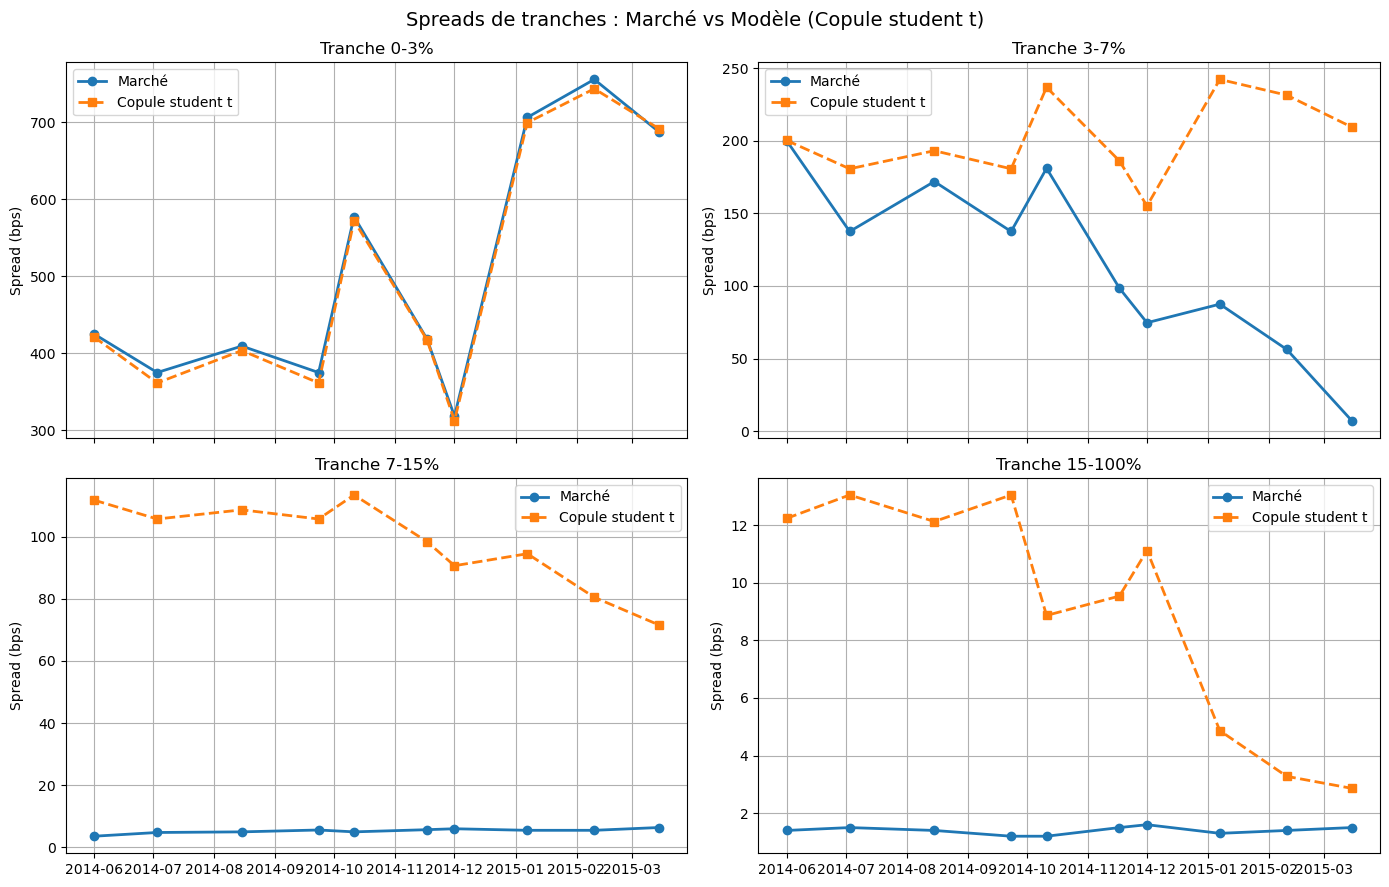

In [12]:
labels = ["0-3%", "3-7%", "7-15%", "15-100%"]
dates = df["Date"]

fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True)
axes = axes.flatten()

for k in range(4):
    ax = axes[k]

    ax.plot(
        dates,
        market_spreads[:, k] * 1e4,
        marker="o",
        label="Marché",
        linewidth=2
    )

    ax.plot(
        dates,
        model_spreads_all_dates[:, k] * 1e4,
        marker="s",
        linestyle="--",
        label="Copule student t",
        linewidth=2
    )

    ax.set_title(f"Tranche {labels[k]}")
    ax.set_ylabel("Spread (bps)")
    ax.grid(True)
    ax.legend()

plt.suptitle("Spreads de tranches : Marché vs Modèle (Copule student t)", fontsize=14)
plt.tight_layout()
plt.show()


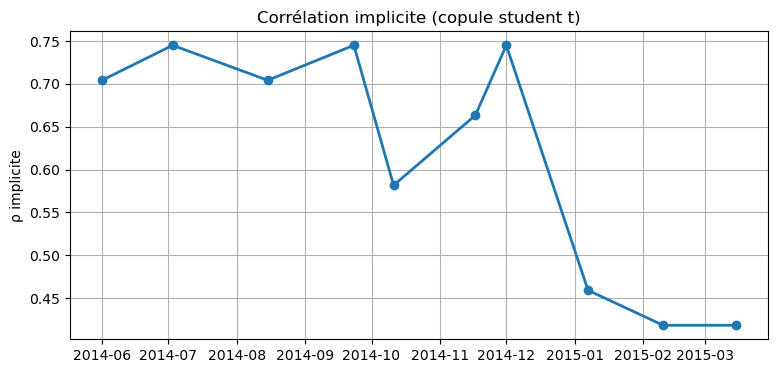

In [13]:
plt.figure(figsize=(9, 4))
plt.plot(dates, rho_t, marker="o", linewidth=2)
plt.ylabel("ρ implicite")
plt.title("Corrélation implicite (copule student t)")
plt.grid(True)
plt.show()


On remarque que le modèle a beaucoup de difficulté à pricer correctement les tranches mezzanines et seniors pour lesquelles il a tendance à surestimer le risque par rapport au marché.

In [14]:
def price_single_tranche(rho, hazard, tranche_index):
    a, d = tranches[tranche_index]

    U = t_copula_uniforms_1factor_crn(
        rho=rho, nu=nu,
        Y=Y_fixed, E=E_fixed, U_chi=U_chi_fixed
    )
    tau = -np.log(U) / hazard
    L_prev = np.zeros(M)
    default_leg = 0.0
    premium_leg = 0.0

    for t in payment_times:
        defaults = (tau <= t).sum(axis=1)
        L = (1 - R) * defaults / N
        Lt = tranche_loss(L, a, d)

        default_leg += discount(t) * np.mean(Lt - L_prev)

        outstanding_prev = d - a - L_prev
        outstanding_now = d - a - Lt
        premium_leg += discount(t) * np.mean(
            0.5 * (outstanding_prev + outstanding_now)
        )

        L_prev = Lt

    if premium_leg < 1e-10:
        return 0.0

    return default_leg / premium_leg


In [15]:
def implied_rho_tranche(market_spread, hazard, tranche_index):

    def objective(x):
        rho = x[0]
        model_spread = price_single_tranche(rho, hazard, tranche_index)
        return (model_spread - market_spread)**2

    res = differential_evolution(
        objective,
        bounds=[(0.01, 0.99)],
        strategy="best1bin",
        maxiter=20,
        popsize=10,
        seed=123,
        polish=True
    )

    return res.x[0]


On décide de calculer le coefficient de corrélation $\rho$ pour chaque tranche. Ceci permet d'observer un "smile" ou "skew" de corrélation, un phénomène connu lié à l'utilisation du modèle de copule gaussienne qui illustre l'impossibilité de pricer correctement chaque tranche. Ceci est notamment lié à l'indépendance des queues de distribution de la copule gaussienne.

In [16]:
attachment_points = [a for a, _ in tranches]

# Essayer de charger le cache du smile
smiles = load_smiles_cache()

if smiles is None:
    # Pas de cache, calculer le smile
    print("Calcul du smile de corrélation (première fois / cache expiré)...")
    smiles = []  # shape: (n_dates, n_tranches)

    for i in range(len(df)):
        h = hazard_from_index(df.loc[i, "CDS_Index"])
        implied_rhos = []

        for k in range(len(tranches)):
            rho_k = implied_rho_tranche(
                market_spreads[i, k],
                h,
                tranche_index=k
            )
            implied_rhos.append(rho_k)

        smiles.append(implied_rhos)

    smiles = np.array(smiles)
    
    # Sauvegarder en cache
    save_smiles_cache(smiles)


Cache smiles chargé: c:\Users\Lucas\OneDrive\Área de Trabalho\MATHAPPLI\PROJET\T-student\cache\smiles_cache.pkl


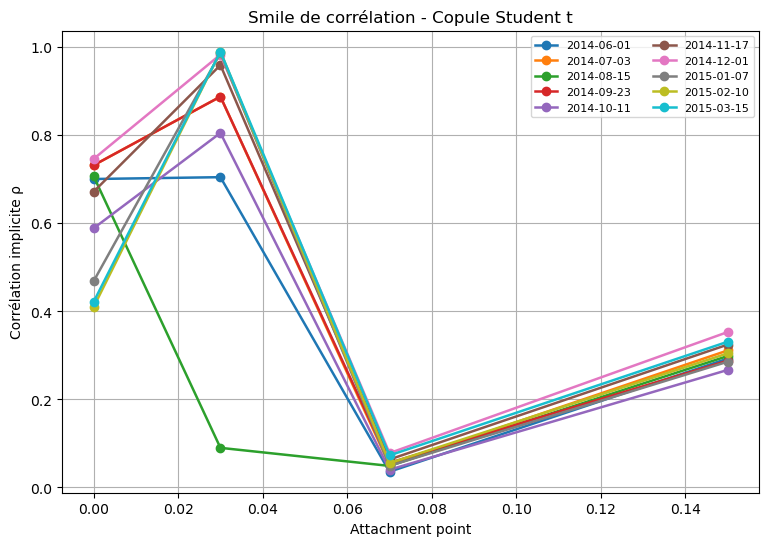

In [17]:
dates = df["Date"]

plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        marker="o",
        linewidth=1.8,
        label=dates[i].strftime("%Y-%m-%d")
    )

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile de corrélation - Copule Student t")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.show()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_14792\3980238815.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


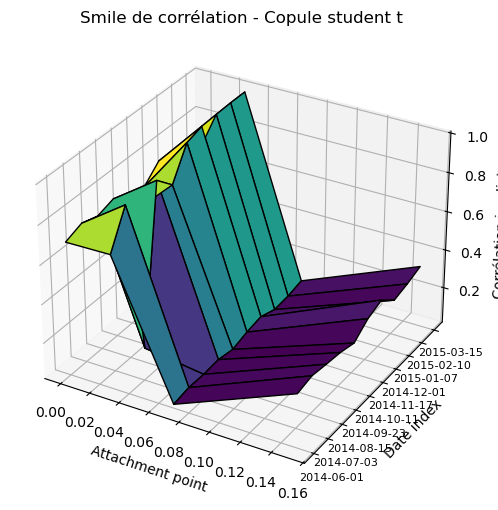

In [19]:
# Surface plot de la smile de corrélation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

# Convert dates to numeric values (days since first date)
dates_numeric = np.arange(len(dates))

X, Y = np.meshgrid(attachment_points, dates_numeric)
Z = smiles
ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")
ax.set_xlabel("Attachment point")
ax.set_ylabel("Date index")
ax.set_zlabel("Corrélation implicite ρ")
ax.set_title("Smile de corrélation - Copule student t")

# Update y-axis labels to show actual dates
date_labels = [d.strftime("%Y-%m-%d") for d in dates]
ax.set_yticks(dates_numeric)
ax.set_yticklabels(date_labels, fontsize=8)

plt.tight_layout()
plt.show()

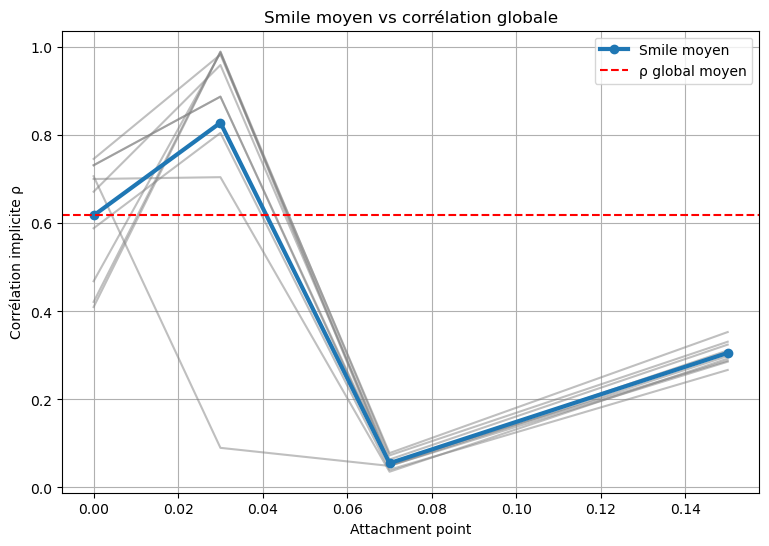

In [20]:
plt.figure(figsize=(9, 6))

for i in range(len(df)):
    plt.plot(
        attachment_points,
        smiles[i],
        color="gray",
        alpha=0.5
    )

plt.plot(
    attachment_points,
    np.mean(smiles, axis=0),
    marker="o",
    linewidth=3,
    label="Smile moyen"
)

plt.axhline(
    np.mean(rho_t),
    color="red",
    linestyle="--",
    label="ρ global moyen"
)

plt.xlabel("Attachment point")
plt.ylabel("Corrélation implicite ρ")
plt.title("Smile moyen vs corrélation globale")
plt.grid(True)
plt.legend()
plt.show()
